Disciplina: Aprendizagem de Máquina Probabilística

Período: 2025.2

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 2 - Modelos de Regressão Bayesiana (Linear, Polinomial e Logística)

## Questão 01

Implemente um modelo de regressão linear Bayesiana para os dados disponíveis em "linear_regression_data.csv". Apresente os seguintes gráficos:

- Os dados originais e a predição a priori do modelo. Indique a incerteza da predição (±2σ).
- Os dados originais e a predição a posteriori do modelo. Indique a incerteza da predição (±2σ).

N pontos: 10
x range: -0.5462970928715938 -> 0.961528396769231
y range: -0.674981469179105 -> 0.14317741370420625
Alpha (prior precision): 1.0
Estimated sigma^2 (from OLS residuals): 0.038732
Estimated noise std (sigma): 0.196805
Beta (noise precision): 25.818329
Posterior mean m_N: [-0.24158722  0.5272629 ]
Posterior covariance S_N:
 [[ 0.00401367 -0.0017647 ]
 [-0.0017647   0.02004023]]


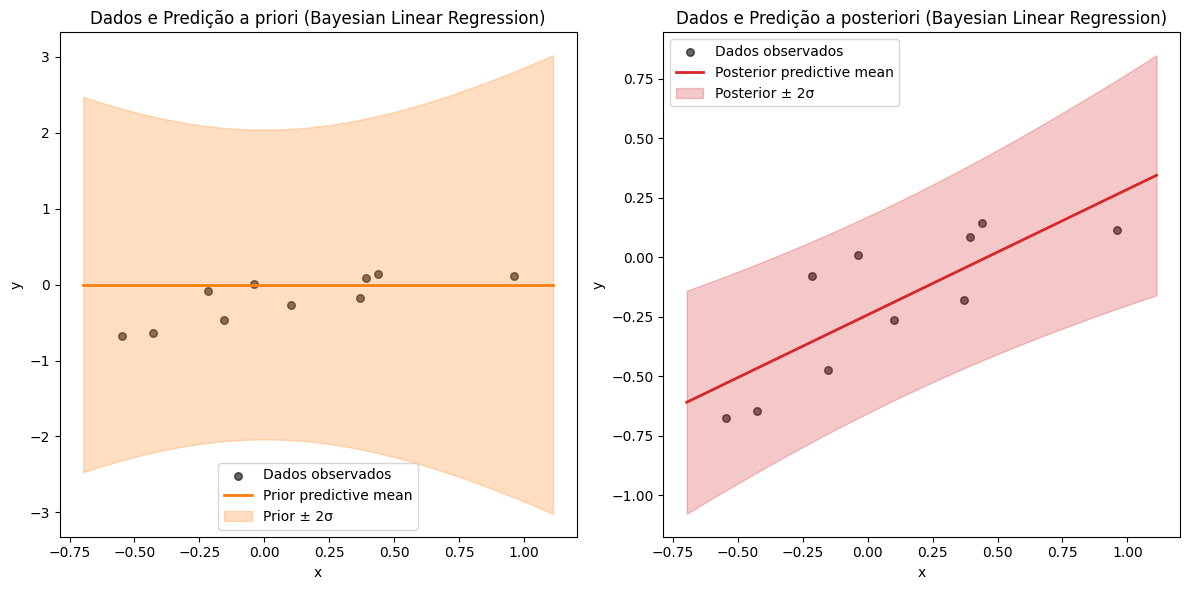


Resumo para relatório:
- Prior precision (alpha): 1.0
- Prior mean m0: [0. 0.]
- Prior covariance S0:
[[1. 0.]
 [0. 1.]]
- Estimated noise std (sigma): 0.196805
- Posterior mean w = [w0, w1]: [-0.24158722  0.5272629 ]
- Posterior covariance S_N:
[[ 0.00401367 -0.0017647 ]
 [-0.0017647   0.02004023]]
- Posterior std (sqrt of diag(S_N)): [0.06335352 0.14156353]


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1) Carregar dados
data = np.genfromtxt('linear_regression_data.csv', delimiter=',')

x = data[:,0].astype(float)
y = data[:,1].astype(float)

# Verificação
print("N pontos:", x.shape[0])
print("x range:", x.min(), "->", x.max())
print("y range:", y.min(), "->", y.max())

# 2) Montar matriz de projeto (com intercepto)
# Design matrix X: col1 = 1 (bias), col2 = x (feature)
X = np.column_stack([np.ones_like(x), x])   # forma (N, 2)
N, D = X.shape  # N pontos, D=2 parâmetros (bias e slope)

# 3) Prior e hiperparâmetros
# Prior: w ~ N(0, alpha^{-1} I)
alpha = 1.0   # precisão do prior
# Prior covariance S0 = (1/alpha) * I
S0 = (1.0 / alpha) * np.eye(D)
m0 = np.zeros(D)  # prior mean (zero)

# 4) Estimativa do ruído (beta = 1/sigma^2)
# Estimar sigma^2 via OLS residual variance (estimador não-Bayesiano, mas simples e prático)
# Solução OLS (mínimos quadrados ordinários)
w_ols = np.linalg.pinv(X.T @ X) @ (X.T @ y)
residuals = y - X @ w_ols
# ddof = D para estimador não viesado
sigma2 = np.sum(residuals**2) / (N - D)

# Proteção contra sigma2 = 0 ou negativo por erro numérico
if sigma2 <= 0:
    sigma2 = 1e-8
beta = 1.0 / sigma2  # precisão da observação

print(f"Alpha (prior precision): {alpha}")
print(f"Estimated sigma^2 (from OLS residuals): {sigma2:.6f}")
print(f"Estimated noise std (sigma): {np.sqrt(sigma2):.6f}")
print(f"Beta (noise precision): {beta:.6f}")

# 5) Posterior analítico (conjugado Gaussian)

A = alpha * np.eye(D) + beta * (X.T @ X) # Posterior precision: alpha * I + beta * X^T X
S_N = np.linalg.inv(A) # Posterior covariance: S_N = (alpha I + beta X^T X)^{-1}
m_N = beta * (S_N @ (X.T @ y)) # Posterior mean: m_N = beta * S_N * X^T y

print("Posterior mean m_N:", m_N)
print("Posterior covariance S_N:\n", S_N)

# 6) Predição (prior e posterior) em uma grid para plot
x_min, x_max = x.min(), x.max()
margin = 0.1 * (x_max - x_min) if x_max > x_min else 1.0
x_plot = np.linspace(x_min - margin, x_max + margin, 300)
X_plot = np.column_stack([np.ones_like(x_plot), x_plot])  # (M, D)

# Prior predictive:
# prior mean for w is m0 -> prior predictive mean = X_plot @ m0 = zeros
prior_mean = X_plot @ m0  # vetor de zeros (M,)
# prior predictive variance: var(y*) = sigma2 + x_*^T S0 x_*
# computamos diag(X_plot @ S0 @ X_plot^T) de forma vetorizada:
prior_var = sigma2 + np.sum((X_plot @ S0) * X_plot, axis=1)
prior_std = np.sqrt(prior_var)

# Posterior predictive:
# mean: X_plot @ m_N
post_mean = X_plot @ m_N
# variance: sigma2 + diag(X_plot @ S_N @ X_plot^T)
post_var = sigma2 + np.sum((X_plot @ S_N) * X_plot, axis=1)
post_std = np.sqrt(post_var)

# 7) Plots
plt.figure(figsize=(12, 6))

# Plot 1: dados + prior predictive mean ± 2σ
plt.subplot(1, 2, 1)
plt.scatter(x, y, s=30, alpha=0.6, label='Dados observados', color='black')
plt.plot(x_plot, prior_mean, color='C1', lw=2, label='Prior predictive mean')
plt.fill_between(x_plot, prior_mean - 2*prior_std, prior_mean + 2*prior_std, color='C1', alpha=0.25, label='Prior ± 2σ')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados e Predição a priori (Bayesian Linear Regression)')
plt.legend()

# Plot 2: dados + posterior predictive mean ± 2σ
plt.subplot(1, 2, 2)
plt.scatter(x, y, s=30, alpha=0.6, label='Dados observados', color='black')
plt.plot(x_plot, post_mean, color='C3', lw=2, label='Posterior predictive mean')
plt.fill_between(x_plot, post_mean - 2*post_std, post_mean + 2*post_std, color='C3', alpha=0.25, label='Posterior ± 2σ')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados e Predição a posteriori (Bayesian Linear Regression)')
plt.legend()

plt.tight_layout()
plt.show()

# ---------- 8) Resumo numérico para relatório ----------
print("\nResumo para relatório:")
print(f"- Prior precision (alpha): {alpha}")
print(f"- Prior mean m0: {m0}")
print(f"- Prior covariance S0:\n{S0}")
print(f"- Estimated noise std (sigma): {np.sqrt(sigma2):.6f}")
print(f"- Posterior mean w = [w0, w1]: {m_N}")
print(f"- Posterior covariance S_N:\n{S_N}")
print(f"- Posterior std (sqrt of diag(S_N)):", np.sqrt(np.diag(S_N)))


## Questão 2

Implemente um modelo de regressão polinomial Bayesiana para os dados disponíveis em polynomial_regression_data.csv. Utilize um modelo polinomial de grau 5. Apresente os seguintes gráficos:

- Os dados originais e a predição a priori do modelo. Indique a incerteza da predição (±2σ).
- Os dados originais e a predição a posteriori do modelo. Indique a incerteza da predição (±2σ).

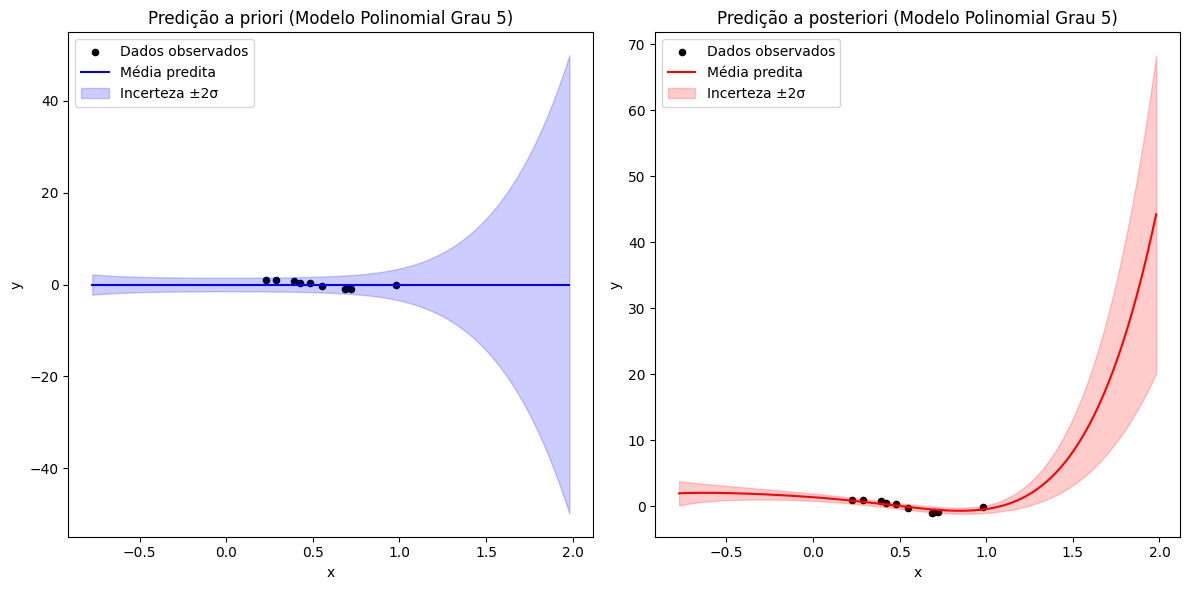

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Carregando os dados
data = np.genfromtxt('polynomial_regression_data.csv', delimiter=',')

X = data[:, 0:1]
y = data[:, 1:2]

# 2. Construindo o modelo polinomial (grau 5)
def design_matrix(X, degree=5):
  #Gera matriz de características polinomiais até o grau especificado.
  return np.hstack([X**i for i in range(degree + 1)])

Phi = design_matrix(X, degree=5)

# 3. Definindo hiperparâmetros
alpha = 2.0  # precisão da priori (1/variância)
beta = 25.0  # precisão do ruído (1/variância)

# 4. Predição a priori
# Média e covariância da priori
m0 = np.zeros((Phi.shape[1], 1))
S0 = (1 / alpha) * np.eye(Phi.shape[1])

# Espaço para visualização
X_plot = np.linspace(X.min() - 1, X.max() + 1, 200).reshape(-1, 1)
Phi_plot = design_matrix(X_plot, degree=5)

# Predição a priori
y_mean_prior = Phi_plot @ m0
y_var_prior = (1 / beta) + np.sum(Phi_plot @ S0 * Phi_plot, axis=1, keepdims=True)

# 5. Cálculo da posteriori
S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T @ Phi
S_N = np.linalg.inv(S_N_inv)
m_N = beta * S_N @ Phi.T @ y

# 6. Predição a posteriori
y_mean_post = Phi_plot @ m_N
y_var_post = (1 / beta) + np.sum(Phi_plot @ S_N * Phi_plot, axis=1, keepdims=True)

# 7. Plotagem
plt.figure(figsize=(12, 6))

# Predição a priori
plt.subplot(1, 2, 1)
plt.title("Predição a priori (Modelo Polinomial Grau 5)")
plt.scatter(X, y, color='black', label='Dados observados', s=20)
plt.plot(X_plot, y_mean_prior, color='blue', label='Média predita')
plt.fill_between(X_plot.ravel(), (y_mean_prior - 2 * np.sqrt(y_var_prior)).ravel(), (y_mean_prior + 2 * np.sqrt(y_var_prior)).ravel(), color='blue', alpha=0.2, label='Incerteza ±2σ')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

# Predição a posteriori
plt.subplot(1, 2, 2)
plt.title("Predição a posteriori (Modelo Polinomial Grau 5)")
plt.scatter(X, y, color='black', label='Dados observados', s=20)
plt.plot(X_plot, y_mean_post, color='red', label='Média predita')
plt.fill_between(X_plot.ravel(), (y_mean_post - 2 * np.sqrt(y_var_post)).ravel(), (y_mean_post + 2 * np.sqrt(y_var_post)).ravel(), color='red', alpha=0.2, label='Incerteza ±2σ')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()


## Questão 3

Implemente um modelo de regressão logística Bayesiana para os dados disponíveis em logistic_regression_data.csv.

- A solução MAP deve ser encontrada através do algoritmo IRLS. A predição pode ser feita via aproximação de Monte Carlo ou via função probit.
- Apresente um gráfico contendo os dados e uma representação da distribuição preditiva encontrada (heat map no espaço bidimensional).

Convergiu em 7 iterações.


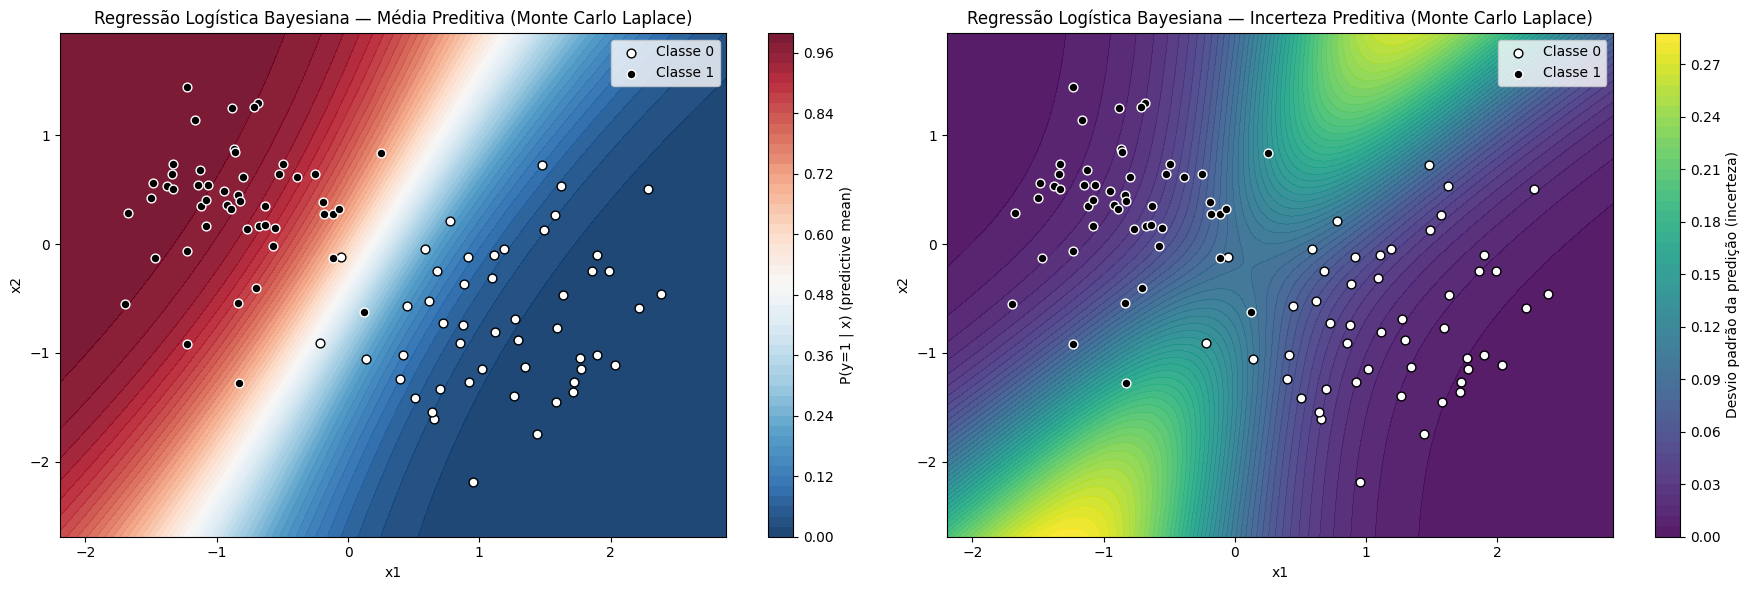


Resumo:
Número de amostras: 100
Dimensão da matriz Phi: (100, 3)
alpha: 1.0
w_MAP: [ 0.5153 -2.8128  1.4486]
Covariância da posterior S_N (shape): (3, 3)
Número de amostras Monte Carlo: 2000


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Carregando os dados
data = np.genfromtxt('logistic_regression_data.csv', delimiter=',')

# Separando as duas primeiras colunas como variáveis de entrada (features)
X_raw = data[:, 0:2]

# Terceira coluna é a variável-alvo (classe)
y = data[:, 2].astype(int)

# Número de amostras (N) e de dimensões de entrada (D_in)
N = X_raw.shape[0]
D_in = X_raw.shape[1]

# 2. Montando a matriz de projeto Φ (Phi)
# Adicionamos uma coluna de 1’s para representar o termo de bias (intercepto)
Phi = np.hstack([np.ones((N, 1)), X_raw])

# Agora Φ tem dimensão [N x (D_in + 1)]
D = Phi.shape[1]

# 3. Definindo o parâmetro de regularização da prior (α)
# α controla a variância da distribuição a priori dos pesos (Normal com média 0 e covariância α⁻¹I)
alpha = 1.0

# 4. Função sigmoide (ligação logística)
# Usada para mapear valores reais (Φw) para probabilidades entre 0 e 1
def sigmoid(z):
  z = np.clip(z, -500, 500)  # evita overflow numérico
  return 1.0 / (1.0 + np.exp(-z))

# 5. Inicializando os pesos e parâmetros do algoritmo IRLS
w = np.zeros(D)     # chute inicial dos pesos
max_iter = 100      # número máximo de iterações
tol = 1e-6          # tolerância para critério de parada

# 6. Algoritmo IRLS (Iteratively Reweighted Least Squares)
# Busca o ponto de máximo a posteriori (MAP) para os pesos w
# equivalente à solução de Newton-Raphson no espaço logístico
for it in range(max_iter):
  # Etapa E: cálculo da predição linear η = Φw
  eta = Phi @ w

  # Probabilidade predita de classe positiva via sigmoide
  mu = sigmoid(eta)

  # Diagonal da matriz de pesos R (variância local da Bernoulli)
  R = mu * (1-mu)

  # Gradiente do log da posterior (negativo)
  grad = - (Phi.T @ (y - mu)) + alpha * w

  # Hessiana da função de custo (segunda derivada
  H = Phi.T @ (R[:,None] * Phi) + alpha * np.eye(D)

  # Resolvendo o sistema linear HΔ = grad para encontrar atualização dos pesos
  try:
    delta = np.linalg.solve(H, grad)
  except np.linalg.LinAlgError:
    # Caso a matriz H não seja invertível, usa pseudoinversa
    delta = np.linalg.pinv(H) @ grad

  # Atualizando os pesos
  w_new = w - delta

  # Critério de convergência — se a variação dos pesos for pequena, paramos
  if np.linalg.norm(w_new - w) < tol:
    w = w_new
    print(f"Convergiu em {it+1} iterações.")
    break

  # Atualiza w para próxima iteração
  w = w_new
else:
  print("IRLS não convergiu dentro do max_iter")

# 7. Solução MAP e matriz de covariância da posterior (Laplace)
w_map = w.copy() # pesos no ponto MAP
eta_map = Phi @ w_map # valores lineares em MAP
mu_map = sigmoid(eta_map) # probabilidades em MAP
R_map = mu_map * (1-mu_map) # matriz diagonal R em MAP

# Hessiana da log-posterior em MAP
H_map = Phi.T @ (R_map[:,None] * Phi) + alpha * np.eye(D)

# A inversa da Hessiana é a covariância aproximada da posterior (Laplace)
try:
  S_N = np.linalg.inv(H_map)
except np.linalg.LinAlgError:
  S_N = np.linalg.pinv(H_map)


# 8. Amostragem Monte Carlo da posterior aproximada
# A posterior é aproximada por uma Gaussiana N(w_map, S_N)
# Geramos várias amostras para estimar a distribuição preditiva

n_samples = 2000 # número de amostras de Monte Carlo
rng = np.random.default_rng(0) # gerador de números aleatórios
jitter = 1e-8 # termo de estabilidade numérica


try:
  # Decomposição de Cholesky (S_N = L Lᵀ)
  L = np.linalg.cholesky(S_N + jitter*np.eye(D))
  ws = w_map[None,:] + (rng.standard_normal((n_samples, D)) @ L.T)
except np.linalg.LinAlgError:
  # Caso a matriz não seja decomposta, usa autovalores e autovetores
  vals, vecs = np.linalg.eigh(S_N)
  vals[vals < 0] = 0.0
  ws = w_map[None,:] + (rng.standard_normal((n_samples, D)) * np.sqrt(vals) @ vecs.T)

# 9. Criando uma grade 2D para visualizar a superfície preditiva
# Define limites de visualização no plano (x1, x2)
x_min, y_min = X_raw.min(axis=0) - 0.5
x_max, y_max = X_raw.max(axis=0) + 0.5

# Cria uma grade uniforme de pontos (200 x 200)
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

# Combina as coordenadas da grade em um array [N_grid x 2]
grid = np.column_stack([xx.ravel(), yy.ravel()])

# Matriz de projeto para todos os pontos da grade (adicionando bias)
Phi_grid = np.hstack([np.ones((grid.shape[0],1)), grid])

# 10. Predição Monte Carlo (média e incerteza)
# Calculamos P(y=1 | x, w) para cada amostra w e cada ponto da grade
probs = 1.0/(1.0 + np.exp(-(Phi_grid @ ws.T)))

# Média da probabilidade sobre todas as amostras (estimação da preditiva)
prob_mean = probs.mean(axis=1)

# Desvio padrão da probabilidade (representa a incerteza preditiva)
prob_std = probs.std(axis=1)

# Remodela os vetores em formato de grade (para o gráfico 2D)
prob_mean_grid = prob_mean.reshape(xx.shape)
prob_std_grid = prob_std.reshape(xx.shape)

# 11. Visualização — Mapa de calor da probabilidade média predita
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, prob_mean_grid, levels=50, cmap='RdBu_r', alpha=0.9)
plt.colorbar(label='P(y=1 | x) (predictive mean)')

# Plotando as classes originais
pos_idx = (y == 1)
neg_idx = (y == 0)
plt.scatter(X_raw[neg_idx, 0], X_raw[neg_idx, 1], c='white', edgecolor='k', label='Classe 0', s=40)
plt.scatter(X_raw[pos_idx, 0], X_raw[pos_idx, 1], c='black', edgecolor='w', label='Classe 1', s=40)

plt.title('Regressão Logística Bayesiana — Média Preditiva (Monte Carlo Laplace)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

# 12. Visualização — Mapa de calor da incerteza preditiva (desvio padrão)
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, prob_std_grid, levels=50, cmap='viridis', alpha=0.9)
plt.colorbar(label='Desvio padrão da predição (incerteza)')

plt.scatter(X_raw[neg_idx, 0], X_raw[neg_idx, 1], c='white', edgecolor='k', label='Classe 0', s=40)
plt.scatter(X_raw[pos_idx, 0], X_raw[pos_idx, 1], c='black', edgecolor='w', label='Classe 1', s=40)

plt.title('Regressão Logística Bayesiana — Incerteza Preditiva (Monte Carlo Laplace)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

plt.tight_layout()
plt.show()

# 13. Resumo final
print("\nResumo:")
print(f"Número de amostras: {N}")
print(f"Dimensão da matriz Phi: {Phi.shape}")
print(f"alpha: {alpha}")
print("w_MAP:", w_map)
print("Covariância da posterior S_N (shape):", S_N.shape)
print(f"Número de amostras Monte Carlo: {n_samples}")


## Conclusão

Ao longo desta atividade, pude compreender na prática, como funciona a ideia de inferência bayesiana em modelos de regressão. Começando pela regressão linear bayesiana, percebi que o modelo não tenta apenas achar uma linha que se ajusta melhor aos dados, mas também leva em conta a incerteza sobre os parâmetros. Já na regressão polinomial bayesiana, vi como o modelo consegue se adaptar a curvas mais complexas e, ao mesmo tempo, controlar o quanto ele confia nas previsões.

A parte da regressão logística foi a mais difícil, mas também a mais interessante. Foi nela que consegui ver como o método bayesiano pode ser aplicado em problemas de classificação, e como o algoritmo IRLS encontra os parâmetros de forma iterativa. A etapa de Monte Carlo, por sua vez, mostrou na prática como podemos propagar essa incerteza até as predições, resultando em regiões de decisão mais realistas. Também achei interessante ver o resultado final com o mapa de calor, mostrando as regiões de decisão e a incerteza das predições.

De forma geral, essa lista me ajudou a entender melhor a importância de considerar a incerteza nos modelos. Isso me deu uma visão mais completa sobre o papel da inferência bayesiana em aprendizado de máquina e como ela se diferencia das abordagens determinísticas tradicionais.